In [12]:
import os
import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import torch


In [49]:
root_path = '/Users/HOME/Desktop/Hackaton/Data/'

f2 = pd.read_csv(root_path + '2019Floor1.csv')

f2 = f2.rename(columns = {'fecha': 'Date'})
f2['Date'] = pd.to_datetime(f2['Date'], format = 'ISO8601')
f2 = f2.set_index('Date')
f2 = f2.asfreq('3H')
f2 = f2.sort_index()
f2 = f2.fillna(0)
f2.to_csv('/Users/HOME/Desktop/Hackaton/Result/energy.csv')
f2

,z1_Light(kW),z2_Light(kW),z3_Light(kW),z4_Light(kW)
Date,,,,
2019-03-01 03:00:00,12.12,6.25,14.45,33.34
2019-03-01 06:00:00,0.01,3.96,19.01,38.69
2019-03-01 09:00:00,0.01,5.34,9.14,0.05
2019-03-01 12:00:00,0.02,8.47,18.59,0.07
2019-03-01 15:00:00,0.02,8.40,18.54,0.07
...,...,...,...,...
2019-12-30 12:00:00,0.01,5.18,12.86,3.80
2019-12-30 15:00:00,0.01,5.27,12.99,3.80
2019-12-30 18:00:00,0.02,6.49,25.25,13.67


In [48]:
ex = pd.read_csv(root_path + '2019weather.csv', encoding='cp949')

ex['일시'] = pd.to_datetime(ex['일시'], format = 'ISO8601')
ex = ex.set_index('일시')
ex = ex.asfreq('3H')
ex = ex.sort_index()
ex.to_csv('/Users/HOME/Desktop/Hackaton/Result/weather.csv')
ex

,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa)
일시,,,,,,
2019-03-01 03:00:00,3.9,0.0,0.2,0,73,1013.8
2019-03-01 06:00:00,2.6,0.0,0.8,360,71,1015.0
2019-03-01 09:00:00,7.2,0.0,3.3,270,46,1015.7
2019-03-01 12:00:00,12.0,0.0,5.2,290,24,1014.1
2019-03-01 15:00:00,14.1,0.0,3.4,290,22,1012.6
...,...,...,...,...,...,...
2019-12-30 12:00:00,5.5,0.0,2.1,270,88,1015.2
2019-12-30 15:00:00,10.5,0.0,2.5,270,73,1013.6
2019-12-30 18:00:00,9.2,0.0,2.6,290,71,1014.5


In [38]:
df = pd.concat([ex, f2], join = 'outer', axis = 1)

df.reset_index(drop = False, inplace= True)
df.to_csv('/Users/HOME/Desktop/Hackaton/Result/total_Data.csv')
df

,index,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),z1_Light(kW),z2_Light(kW),z3_Light(kW),z4_Light(kW)
0,2019-03-01 03:00:00,3.9,0.0,0.2,0,73,1013.8,12.12,6.25,14.45,33.34
1,2019-03-01 06:00:00,2.6,0.0,0.8,360,71,1015.0,0.01,3.96,19.01,38.69
2,2019-03-01 09:00:00,7.2,0.0,3.3,270,46,1015.7,0.01,5.34,9.14,0.05
3,2019-03-01 12:00:00,12.0,0.0,5.2,290,24,1014.1,0.02,8.47,18.59,0.07
4,2019-03-01 15:00:00,14.1,0.0,3.4,290,22,1012.6,0.02,8.40,18.54,0.07
...,...,...,...,...,...,...,...,...,...,...,...
2435,2019-12-30 12:00:00,5.5,0.0,2.1,270,88,1015.2,0.01,5.18,12.86,3.80
2436,2019-12-30 15:00:00,10.5,0.0,2.5,270,73,1013.6,0.01,5.27,12.99,3.80
2437,2019-12-30 18:00:00,9.2,0.0,2.6,290,71,1014.5,0.02,6.49,25.25,13.67
2438,2019-12-30 21:00:00,6.4,0.0,5.7,290,50,1015.4,8.28,4.28,33.53,12.35


In [19]:
#데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32             #수정
features = ['기온(°C)',
            '강수량(mm)',
            '풍속(m/s)',
            '풍향(16방위)',
            '습도(%)',
            '현지기압(hPa)',
            'z1_Light(kW)',
            'z2_Light(kW)',
            'z3_Light(kW)',
            'z4_Light(kW)']
n_features = len(features)
TRAIN_SIZE = int(len(df) * 0.7)

In [20]:
# 데이터 전처리 - 표준정규분포화
scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [21]:
# keras TimeseriesGenerator를 이용해 데이터셋 만들기
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

In [22]:
valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

In [23]:
print(train_gen[0][0].shape)  # (32, 10, 5)
print(train_gen[0][1].shape)  # (32, 5)

(32, 10, 10)
(32, 10)


In [24]:
# 모델만들기
# 2개 층의 LSTM으로 인코더 만듬
# RepeatVector는 input을 window_size만큼 복사해줌
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

In [25]:
model.compile(loss='mse', optimizer='adam',metrics=["mse"])

In [26]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50)

Epoch 1/50
76/76 [==============================] - 5s 17ms/step - loss: 3.8562 - mse: 3.8562 - val_loss: 1.2291 - val_mse: 1.2291
Epoch 2/50
76/76 [==============================] - 1s 11ms/step - loss: 0.9805 - mse: 0.9805 - val_loss: 0.9674 - val_mse: 0.9674
Epoch 3/50
76/76 [==============================] - 1s 11ms/step - loss: 0.9038 - mse: 0.9038 - val_loss: 0.9039 - val_mse: 0.9039
Epoch 4/50
76/76 [==============================] - 1s 11ms/step - loss: 0.8629 - mse: 0.8629 - val_loss: 0.8394 - val_mse: 0.8394
Epoch 5/50
76/76 [==============================] - 1s 11ms/step - loss: 0.8459 - mse: 0.8459 - val_loss: 0.8301 - val_mse: 0.8301
Epoch 6/50
76/76 [==============================] - 1s 11ms/step - loss: 0.8155 - mse: 0.8155 - val_loss: 0.8013 - val_mse: 0.8013
Epoch 7/50
76/76 [==============================] - 1s 11ms/step - loss: 0.7996 - mse: 0.7996 - val_loss: 0.7860 - val_mse: 0.7860
Epoch 8/50
76/76 [==============================] - 1s 11ms/step - loss: 0.7789 - m

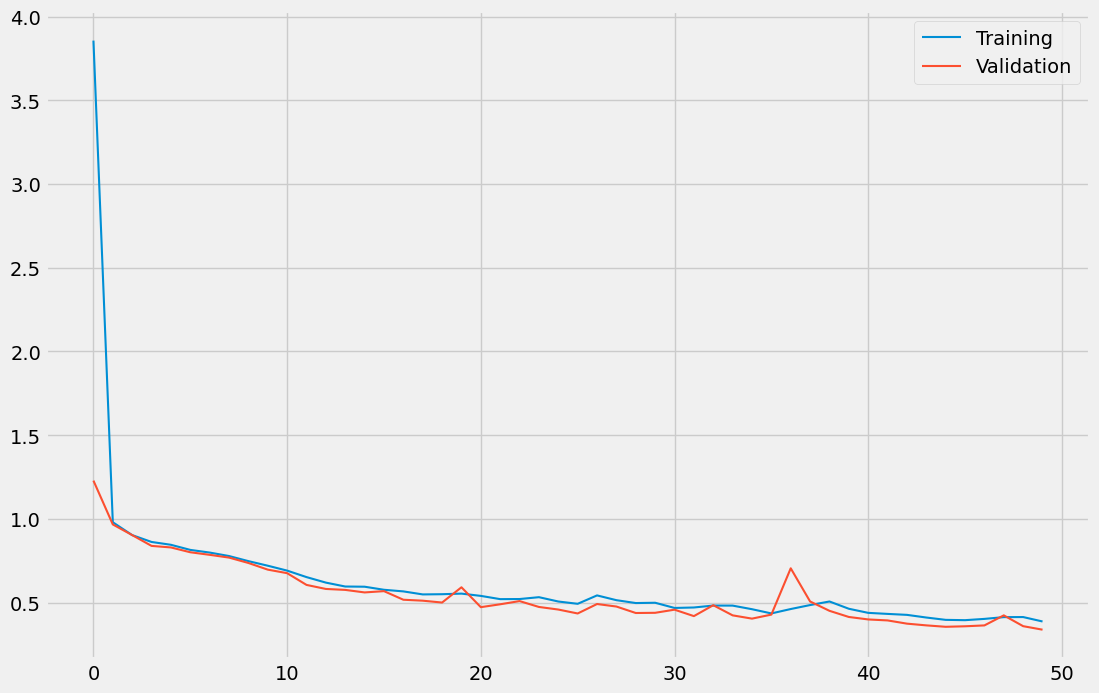

In [27]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

76/76 [==============================] - 1s 3ms/step


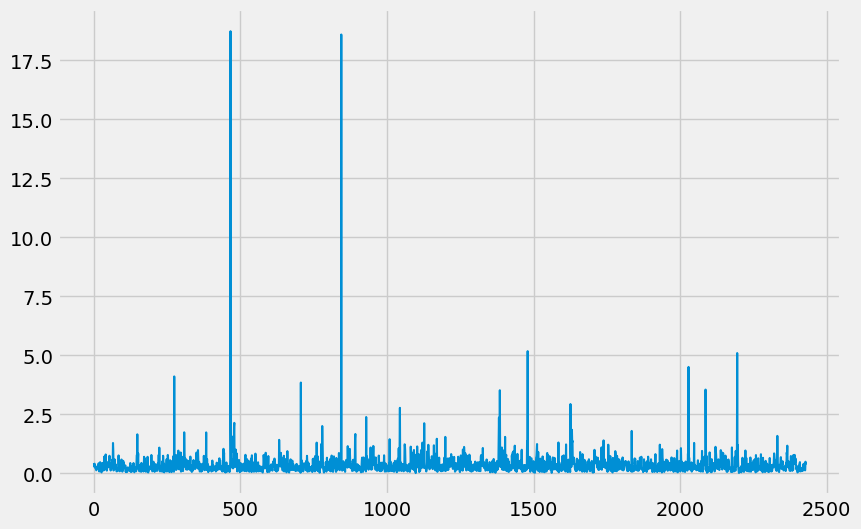

In [28]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mse_loss = np.mean((pred-real)**2, axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
plt.plot(mse_loss, label='mse_loss')

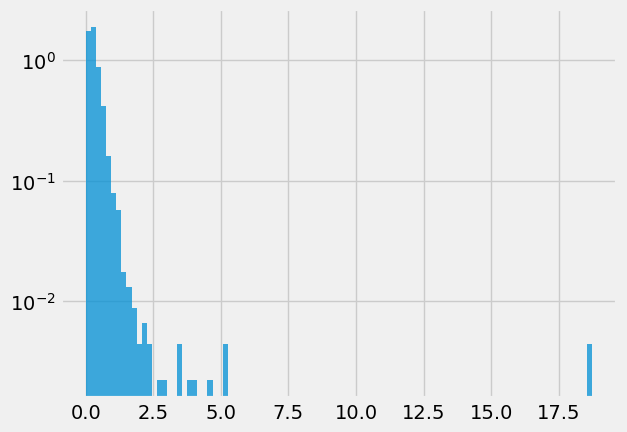

In [46]:
_ = plt.hist(mse_loss, 100, density=True, alpha=0.75, log=True)

In [47]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mse_loss

threshold = 5
loss = test_df.loc[test_df.Loss>threshold]

loss.to_csv('/Users/HOME/Desktop/Hackaton/Result/Loss_Data.csv')

In [52]:
loss = loss.replace('2019','2020')
loss.to_csv('/Users/HOME/Desktop/Hackaton/Result/Predict_Loss_Data.csv')